## Exercise 2: Image Registration with VoxelMorph

For this problem, you are required to register two volumes sampled randomly from a dataset, where one volume serves as the fixed (target) volume and the other as the moving (source) volume. This task is referred to as unpaired registration or inter-subject registration and is crucial for various downstream tasks such as voxel-based morphometry (VBM), atlas construction, and atlas-based segmentation.

![alt text](https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis-teaser.png)


Here, we will use the [Neurite OASIS Dataset](https://github.com/adalca/medical-datasets/blob/master/neurite-oasis.md), which contains several types of images for each subject:
1. Original 3D volumes (`orig.nii.gz` and corresponding segmentation maps `seg4.nii.gz` and `seg35.nii.gz`).
2. Affinely aligned 3D volumes to freesurfer's talairach space (`aligned_orig.nii.gz` and corresponding segmentation maps `aligned_seg4.nii.gz` and `aligned_seg35.nii.gz`).
3. Original 2D slices (`slice_orig.nii.gz` and corresponding segmentation maps `slice_seg4.nii.gz` and `slice_seg35.nii.gz`).

To learn more about this dataset, please check [this description](https://github.com/adalca/medical-datasets/blob/master/neurite-oasis.md) and [The Open Access Series of Imaging Studies (OASIS)](https://oasis-brains.org/).

To simply this task, only the affinely aligned normalized volumes (`aligned_norm.nii.gz`) and their corresponding 4-label segmentation maps (`aligned_seg4.nii.gz`) are used for training. The 35-label segmentation maps (`aligned_seg35.nii.gz`) are only used for validation and visualization purposes.

Please note that the original challenge involves evaluating the quality of registration using three metrics: Dice Similarity Coefficient (DSC), 95% percentile of Hausdorff distance (HD95) of segmentations, and standard deviation of the log Jacobian determinant of the deformation field (SDlogJ). DSC and HD95 assess how well the model aligns different anatomical structures, while SDlogJ measures the smoothness of the predicted deformation between the fixed and moving images. For your homework, only DSC is evaluated for simplicity.

## Setup Environment

In [11]:
!pip install -q --user "monai-weekly[tensorboard]"
%matplotlib inline
# Download the utility code and check GPU status
!wget -q https://raw.githubusercontent.com/charlesyou999648/MedIA/main/homework4/modelio.py
!nvidia-smi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 76.6 MB/s eta 0:00:00
Sat May 10 14:28:27 2025       
+-----------------------------------------------------------------------------------------+

In [ ]:
! pip install monai

In [15]:
# Import necessary packages
import os
import glob
import tempfile
import time
import warnings
from pprint import pprint
import shutil

import torch
from torch.nn import MSELoss
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from monai.apps import download_and_extract
from monai.data import Dataset, DataLoader
from monai.losses import BendingEnergyLoss, DiceLoss
from monai.metrics import DiceMetric
from monai.networks.blocks import Warp
from monai.networks.utils import one_hot
from monai.utils import set_determinism, first
from monai.visualize.utils import blend_images
from monai.config import print_config
from monai.transforms import LoadImaged

# Setting deterministic behavior for reproducibility.
set_determinism(seed=0)

# Configuring CUDA for better performance.
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Ignoring warnings for cleaner output.
warnings.filterwarnings("ignore")


You have the option to indicate a directory using the `MONAI_DATA_DIRECTORY` environment variable. This feature enables you to store your results and retrieve previously downloaded data. In case you don't specify a directory, a temporary directory will be automatically utilized.

In [16]:
# Getting the MONAI data directory from the environment variables.
directory = os.environ.get("MONAI_DATA_DIRECTORY")

# If MONAI_DATA_DIRECTORY is not set, create a temporary directory.
# Otherwise, use the specified directory.
root_dir = tempfile.mkdtemp() if directory is None else directory

print(root_dir)  # Printing the root directory path.

/tmp/tmp62sythyp


## Download dataset and prepare datalist
Download and extract the dataset:

In [17]:
# Define the URL from which the resource (in this case, a compressed file) will be downloaded.
resource = "https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.v1.0.tar"

# Create the path for the compressed file by joining the root directory path with the filename.
compressed_file = os.path.join(root_dir, "neurite-oasis.v1.0.tar")

# Create the path for the directory where the extracted data will be stored by joining the root directory path with the directory name.
data_dir = os.path.join(root_dir, "OASIS")

# Check if the data directory does not exist.
if not os.path.exists(data_dir):
    # If the data directory does not exist, create it.
    os.mkdir(data_dir)
    # Download and extract the resource (compressed file) to the specified data directory.
    download_and_extract(resource, compressed_file, data_dir)


neurite-oasis.v1.0.tar: 100%|██████████| 6.53G/6.53G [11:30<00:00, 10.2MB/s]

2025-05-10 14:41:26,894 - INFO - Downloaded: /tmp/tmp62sythyp/neurite-oasis.v1.0.tar
2025-05-10 14:41:26,895 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmp62sythyp/neurite-oasis.v1.0.tar.
2025-05-10 14:41:26,895 - INFO - Writing into directory: /tmp/tmp62sythyp/OASIS.


Get list of samples in the dataset:

In [18]:
def get_files(data_dir):
    """
    Get train/val files from the full OASIS dataset

    Args:
        data_dir (str): Directory path where the dataset is stored.

    Returns:
        train_files (list): List of dictionaries containing file paths for training data.
        val_files (list): List of dictionaries containing file paths for validation data.
    """

    # Define the path to the text file containing the list of subjects.
    data_txt = os.path.join(data_dir, "subjects.txt")

    # Initialize an empty list to store folder names.
    folders = []

    # Open the text file and read folder names line by line.
    with open(data_txt, "r") as file:
        for line in file:
            folders.append(str(line).strip())

    # Initialize empty lists to store file paths for training and validation data.
    train_files = []
    val_files = []

    # Load images and segmentations for training set.
    for folder in folders[:394]:
        train_files.append(
            {
                "image": os.path.join(data_dir, folder, "aligned_norm.nii.gz"),
                "label_4": os.path.join(data_dir, folder, "aligned_seg4.nii.gz"),
                "label_35": os.path.join(data_dir, folder, "aligned_seg35.nii.gz"),
            }
        )

    # Load images and segmentations for validation set.
    for i, folder in enumerate(folders[394:-1]):
        next_folder = folders[394:][i + 1]
        val_files.append(
            {
                "fixed_image": os.path.join(data_dir, folder, "aligned_norm.nii.gz"),
                "moving_image": os.path.join(data_dir, next_folder, "aligned_norm.nii.gz"),
                "fixed_label_4": os.path.join(data_dir, folder, "aligned_seg4.nii.gz"),
                "moving_label_4": os.path.join(data_dir, next_folder, "aligned_seg4.nii.gz"),
                "fixed_label_35": os.path.join(data_dir, folder, "aligned_seg35.nii.gz"),
                "moving_label_35": os.path.join(data_dir, next_folder, "aligned_seg35.nii.gz"),
            }
        )

    return train_files, val_files


# Call the function to get training and validation files.
train_files, val_files = get_files(data_dir)

# Print 1 training sample and 1 validation sample to illustrate the contents of the datalist.
pprint(train_files[0])
pprint(val_files[0])


{'image': '/tmp/tmp62sythyp/OASIS/OASIS_OAS1_0001_MR1/aligned_norm.nii.gz',
 'label_35': '/tmp/tmp62sythyp/OASIS/OASIS_OAS1_0001_MR1/aligned_seg35.nii.gz',
 'label_4': '/tmp/tmp62sythyp/OASIS/OASIS_OAS1_0001_MR1/aligned_seg4.nii.gz'}
{'fixed_image': '/tmp/tmp62sythyp/OASIS/OASIS_OAS1_0438_MR1/aligned_norm.nii.gz',
 'fixed_label_35': '/tmp/tmp62sythyp/OASIS/OASIS_OAS1_0438_MR1/aligned_seg35.nii.gz',
 'fixed_label_4': '/tmp/tmp62sythyp/OASIS/OASIS_OAS1_0438_MR1/aligned_seg4.nii.gz',
 'moving_image': '/tmp/tmp62sythyp/OASIS/OASIS_OAS1_0439_MR1/aligned_norm.nii.gz',
 'moving_label_35': '/tmp/tmp62sythyp/OASIS/OASIS_OAS1_0439_MR1/aligned_seg35.nii.gz',
 'moving_label_4': '/tmp/tmp62sythyp/OASIS/OASIS_OAS1_0439_MR1/aligned_seg4.nii.gz'}


Define transforms for training and validation sets:

In [19]:
# Define the transformation for loading images and labels for training data.
transform_train = LoadImaged(keys=["image", "label_4", "label_35"], ensure_channel_first=True)

# Define the transformation for loading images and labels for validation data.
transform_val = LoadImaged(
    keys=["fixed_image", "moving_image", "fixed_label_4", "moving_label_4", "fixed_label_35", "moving_label_35"],
    ensure_channel_first=True,
)


## Data Visualizations and Transformations

Visualize a single batch with a single sample to check the transforms.

## 🚩 YOUR TASK: Data Visualization
(1) Extract the coronal slice 100 from the image and blended image.\
(2) Plot the original image and the blended image with overlaid label.\
(3) Remove ticks from the plot.\
(4) Set the title and layout of the plot.\
(5) Display the plot.\
(6) In the same way, please also display the axial and sagittal slices (display slice 100 as an example).


torch.Size([1, 160, 192, 224])


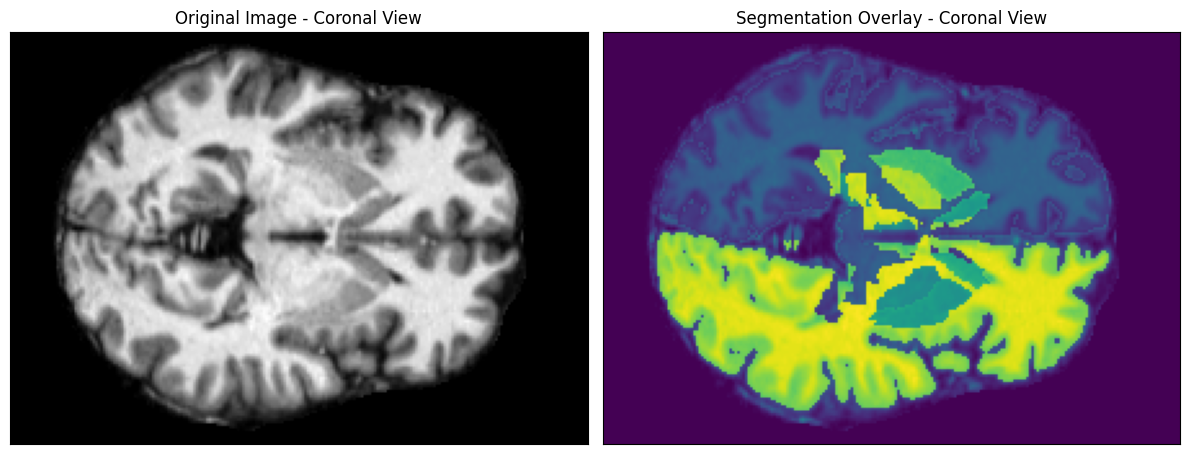

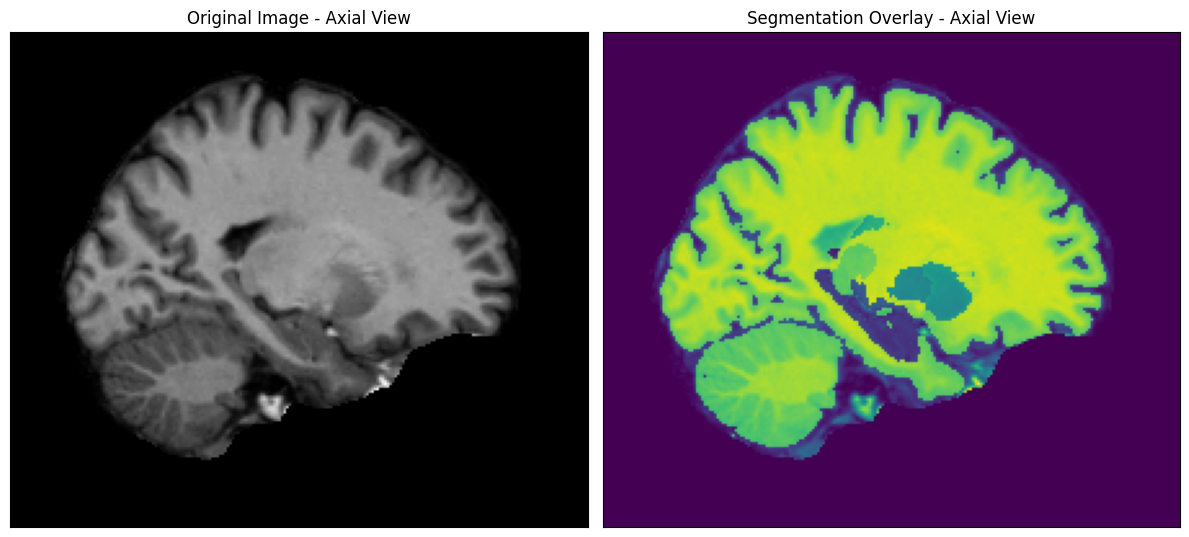

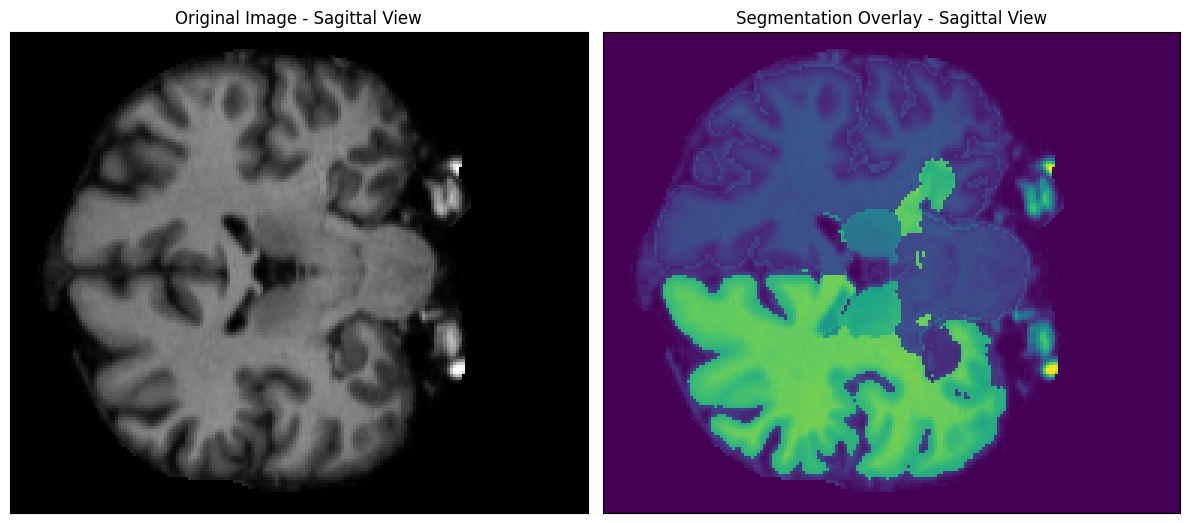

In [20]:
# Set deterministic behavior for reproducibility.
set_determinism(seed=0)

# Create a dataset using the training files and the defined transformation.
check_ds = Dataset(data=train_files, transform=transform_train)

# Create a data loader for the dataset with batch size 1 and shuffling enabled.
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)

# Get the first batch of data from the data loader.
check_data = first(check_loader)

# Extract the image and label from the batch.
image = check_data["image"][0]
print(image.shape)  # Print the shape of the image.

label = check_data["label_35"][0]

# Blend the image and label for visualization.
blended = blend_images(image, label)

############# YOUR CODES START #############

# Extract the coronal slice 100 from the image and blended image.
coronal_image = image[0, :, 100, :]
coronal_blended = blended[0, :, 100, :]

# Plot the original image and the blended image with overlaid label.
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(coronal_image, cmap='gray')
axs[1].imshow(coronal_blended)

# Remove ticks from the plot.
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
# Set the title and layout of the plot.
axs[0].set_title('Original Image - Coronal View')
axs[1].set_title('Segmentation Overlay - Coronal View')
plt.tight_layout()
# Display the plot.
plt.show()

# Extract the axial slice 100 from the image and blended image.
axial_image = image[0, 100, :, :]
axial_blended = blended[0, 100, :, :]

# Plot the original image and the blended image with overlaid label.
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(axial_image, cmap='gray')
axs[1].imshow(axial_blended)

# Remove ticks from the plot.
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
# Set the title and layout of the plot.
axs[0].set_title('Original Image - Axial View')
axs[1].set_title('Segmentation Overlay - Axial View')
plt.tight_layout()

# Display the plot.
plt.show()

# Extract the sagittal slice 100 from the image and blended image.
sagittal_image = image[0, :, :, 100]
sagittal_blended = blended[0, :, :, 100]

# Plot the original image and the blended image with overlaid label.
fig, axs = plt.subplots(1, 2 , figsize=(12, 6))
axs[0].imshow(sagittal_image, cmap='gray')
axs[1].imshow(sagittal_blended)

# Remove ticks from the plot.
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
# Set the title and layout of the plot.
axs[0].set_title('Original Image - Sagittal View')
axs[1].set_title('Segmentation Overlay - Sagittal View')
plt.tight_layout()
# Display the plot.
plt.show()
############# YOUR CODES END #############


# Define Layers and Build the Network

## Set Hyper-Parameters

There are numerous possibilities for customizing and conducting hyperparameter searches in the exploration of loss weights. However, in this example, we will stick to the same loss weights as those outlined in the [original VoxelMorph paper](https://arxiv.org/pdf/1809.05231.pdf).


In [21]:
# device, optimizer, epoch, and batch settings
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use CUDA if available, otherwise use CPU
batch_size = 1  # Batch size for training
lr = 1e-4  # Learning rate for the optimizer
weight_decay = 1e-5  # Weight decay parameter for regularization
max_epochs = 3  # Maximum number of epochs for training

# Use mixed precision feature of GPUs for faster training
amp_enabled = True  # Flag to enable automatic mixed precision training

# Loss weights (set to zero to disable loss term)
lam_sim = 1e0  # Weight for MSE (Mean Squared Error) loss for image similarity
lam_smooth = 1e-2  # Weight for bending loss for smoothness regularization
lam_dice = 2e-2  # Weight for Dice loss for auxiliary segmentation

# Whether to use coarse (4-label) or fine (35-label) labels for training
use_coarse_labels = True  # Flag to indicate whether to use coarse labels for training

# Write model and tensorboard logs?
do_save = True  # Flag to indicate whether to save model and logs
dir_save = os.path.join(os.getcwd(), "models", "voxelmorph")  # Directory to save models and logs
if do_save and not os.path.exists(dir_save):  # Create directory if it doesn't exist
    os.makedirs(dir_save)


## 🚩 YOUR TASK: Velocity Field Integration
In this part you are required to implement procedure for stationary velocity field integration called Scaling and Squaring.

This procedure was discussed in the class and Prof. Batmanghelich has shared a [paper](https://piazza.com/class_profile/get_resource/lr6xmjo4mw84z0/ludgiyd32l363) that you can read about.

The general idea is this: to obtain the deformation, you need to integrate the velocity field over time $$ \phi_1 = \int_0^1 v(\phi_t)dt. $$

The scaling and squaring can be viewed as compistion of smaller deformation ($\phi_1  = \phi_{1/2} \circ \phi_{1/2}$) and $\phi_{1/2}$ can be decomposed recursively using $\phi_{1/4}$, etc. The procedure involves scalling the original velocity field and composing intermediate deformation field.

Please read the [paper](https://piazza.com/class_profile/get_resource/lr6xmjo4mw84z0/ludgiyd32l363) for more detail. You can use `SpatialTransformer` for composition of the deformation , please fill up the question below.

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as nnf


class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """
    def __init__(self, size, mode='bilinear'):
        super().__init__()

        self.mode = mode

        # create sampling grid
        vectors = [torch.arange(0, s) for s in size]
        grids = torch.meshgrid(vectors)
        grid = torch.stack(grids)
        grid = torch.unsqueeze(grid, 0)
        grid = grid.type(torch.FloatTensor)

        # registering the grid as a buffer cleanly moves it to the GPU
        self.register_buffer('grid', grid)

    def forward(self, src, flow):
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return nnf.grid_sample(src, new_locs, align_corners=True, mode=self.mode)


class ScaleAndSquare(nn.Module):
    """
    Integrates a vector field via scaling and squaring.
    """

    def __init__(self, inshape, nsteps):
        super().__init__()

        assert nsteps >= 0, 'nsteps should be >= 0, found: %d' % nsteps
        self.nsteps = nsteps
        self.scale = 1.0 / (2 ** self.nsteps)
        self.transformer = SpatialTransformer(inshape)
        # self.transformer = None
        # self.inshape = inshape

    def forward(self, vec):
        ############# YOUR CODES START #############
        # if self.transformer is None or self.transformer.grid.shape[2:] != vec.shape[2:]:
        #     self.transformer = SpatialTransformer(vec.shape[2:])
        #     if vec.is_cuda:
        #         self.transformer = self.transformer.to(vec.device)
        vec = vec * self.scale
        flow = vec
        for _ in range(self.nsteps):
        # Compose the flow with itself
        # This is equivalent to phi_{t/2} ∘ phi_{t/2} = phi_t
        # We compute this by warping the current flow field with itself
            flow = flow + self.transformer(flow, flow)

        ############# YOUR CODES END #############

        return flow


class ResizeTransform(nn.Module):
    """
    Resize a transform, which involves resizing the vector field *and* rescaling it.
    """

    def __init__(self, vel_resize, ndims):
        super().__init__()
        self.factor = 1.0 / vel_resize
        self.mode = 'linear'
        if ndims == 2:
            self.mode = 'bi' + self.mode
        elif ndims == 3:
            self.mode = 'tri' + self.mode

    def forward(self, x):
        if self.factor < 1:
            # resize first to save memory
            x = nnf.interpolate(x, align_corners=True, scale_factor=self.factor, mode=self.mode)
            x = self.factor * x

        elif self.factor > 1:
            # multiply first to save memory
            x = self.factor * x
            x = nnf.interpolate(x, align_corners=True, scale_factor=self.factor, mode=self.mode)

        # don't do anything if resize is 1
        return x


**Your task:** Please explain the function of each line for the ``forward`` function of the ``ScaleAndSquare`` class below:

So, the function represents taking a very small initial step in the integration process by Scaling down the velocity field by the factor

flow = vec -> Initializes the flow field with the scaled velocity
- At a very small time step, the flow field can be approximated by the scaled velocity field

flow = flow + self.transformer(flow, flow) -> Each iteration of this loop represents "squaring" the current flow field, doubling the integration time. After nsteps iterations, we will have integrated from time 0 to time 1.

the purpose of the function is scaling and squaring which performs the mathematical composition of deformation feilds

1. scaling: Computing exp(v/2^N) ≈ v/2^N for large enough N
2. Squaring: Repeatedly squaring the result: exp(v) = exp(v/2^N)^(2^N)


## 🚩 YOUR TASK: Convert the Input to Flow Field
(1) Concatenate the source and target images along the channel dimension.\
(2) Pass the resulting image through the U-Net.\
(Note: we have already made that for you in the constructor , `__init__`, and you just need to find it.)\
(3) Pass the output of the U-Net through a convolution that generates vector field where the output is the dimensionality of the image.


In [37]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

from modelio import LoadableModel, store_config_args


def default_unet_features():
    nb_features = [
        [16, 32, 32, 32],             # encoder
        [32, 32, 32, 32, 32, 16, 16]  # decoder
    ]

    return nb_features


class Unet(nn.Module):
    """
    A unet architecture. Layer features can be specified directly as a list of encoder and decoder
    features or as a single integer along with a number of unet levels. The default network features
    per layer (when no options are specified) are:

        encoder: [16, 32, 32, 32]
        decoder: [32, 32, 32, 32, 32, 16, 16]
    """

    def __init__(self,
                 inshape=None,
                 infeats=None,
                 nb_features=None,
                 nb_levels=None,
                 max_pool=2,
                 feat_mult=1,
                 nb_conv_per_level=1,
                 half_res=False):
        """
        Parameters:
            inshape: Input shape. e.g. (192, 192, 192)
            infeats: Number of input features.
            nb_features: Unet convolutional features. Can be specified via a list of lists with
                the form [[encoder feats], [decoder feats]], or as a single integer.
                If None (default), the unet features are defined by the default config described in
                the class documentation.
            nb_levels: Number of levels in unet. Only used when nb_features is an integer.
                Default is None.
            feat_mult: Per-level feature multiplier. Only used when nb_features is an integer.
                Default is 1.
            nb_conv_per_level: Number of convolutions per unet level. Default is 1.
            half_res: Skip the last decoder upsampling. Default is False.
        """

        super().__init__()

        # ensure correct dimensionality
        ndims = len(inshape)
        assert ndims in [1, 2, 3], 'ndims should be one of 1, 2, or 3. found: %d' % ndims

        # cache some parameters
        self.half_res = half_res

        # default encoder and decoder layer features if nothing provided
        if nb_features is None:
            nb_features = default_unet_features()

        # build feature list automatically
        if isinstance(nb_features, int):
            if nb_levels is None:
                raise ValueError('must provide unet nb_levels if nb_features is an integer')
            feats = np.round(nb_features * feat_mult ** np.arange(nb_levels)).astype(int)
            nb_features = [
                np.repeat(feats[:-1], nb_conv_per_level),
                np.repeat(np.flip(feats), nb_conv_per_level)
            ]
        elif nb_levels is not None:
            raise ValueError('cannot use nb_levels if nb_features is not an integer')

        # extract any surplus (full resolution) decoder convolutions
        enc_nf, dec_nf = nb_features
        nb_dec_convs = len(enc_nf)
        final_convs = dec_nf[nb_dec_convs:]
        dec_nf = dec_nf[:nb_dec_convs]
        self.nb_levels = int(nb_dec_convs / nb_conv_per_level) + 1

        if isinstance(max_pool, int):
            max_pool = [max_pool] * self.nb_levels

        # cache downsampling / upsampling operations
        MaxPooling = getattr(nn, 'MaxPool%dd' % ndims)
        self.pooling = [MaxPooling(s) for s in max_pool]
        self.upsampling = [nn.Upsample(scale_factor=s, mode='nearest') for s in max_pool]

        # configure encoder (down-sampling path)
        prev_nf = infeats
        encoder_nfs = [prev_nf]
        self.encoder = nn.ModuleList()
        for level in range(self.nb_levels - 1):
            convs = nn.ModuleList()
            for conv in range(nb_conv_per_level):
                nf = enc_nf[level * nb_conv_per_level + conv]
                convs.append(ConvBlock(ndims, prev_nf, nf))
                prev_nf = nf
            self.encoder.append(convs)
            encoder_nfs.append(prev_nf)

        # configure decoder (up-sampling path)
        encoder_nfs = np.flip(encoder_nfs)
        self.decoder = nn.ModuleList()
        for level in range(self.nb_levels - 1):
            convs = nn.ModuleList()
            for conv in range(nb_conv_per_level):
                nf = dec_nf[level * nb_conv_per_level + conv]
                convs.append(ConvBlock(ndims, prev_nf, nf))
                prev_nf = nf
            self.decoder.append(convs)
            if not half_res or level < (self.nb_levels - 2):
                prev_nf += encoder_nfs[level]

        # now we take care of any remaining convolutions
        self.remaining = nn.ModuleList()
        for num, nf in enumerate(final_convs):
            self.remaining.append(ConvBlock(ndims, prev_nf, nf))
            prev_nf = nf

        # cache final number of features
        self.final_nf = prev_nf

    def forward(self, x):

        # encoder forward pass
        x_history = [x]
        for level, convs in enumerate(self.encoder):
            for conv in convs:
                x = conv(x)
            x_history.append(x)
            x = self.pooling[level](x)

        # decoder forward pass with upsampling and concatenation
        for level, convs in enumerate(self.decoder):
            for conv in convs:
                x = conv(x)
            if not self.half_res or level < (self.nb_levels - 2):
                x = self.upsampling[level](x)
                x = torch.cat([x, x_history.pop()], dim=1)

        # remaining convs at full resolution
        for conv in self.remaining:
            x = conv(x)

        return x


class VoxelMorph(LoadableModel):
    """
    VoxelMorph network for (unsupervised) nonlinear registration between two images.
    """

    @store_config_args
    def __init__(self,
                 inshape,
                 nb_unet_features=None,
                 nb_unet_levels=None,
                 unet_feat_mult=1,
                 nb_unet_conv_per_level=1,
                 int_steps=7,
                 int_downsize=2,
                 bidir=False,
                 use_probs=False,
                 src_feats=1,
                 trg_feats=1,
                 unet_half_res=False):
        """
        Parameters:
            inshape: Input shape. e.g. (192, 192, 192)
            nb_unet_features: Unet convolutional features. Can be specified via a list of lists with
                the form [[encoder feats], [decoder feats]], or as a single integer.
                If None (default), the unet features are defined by the default config described in
                the unet class documentation.
            nb_unet_levels: Number of levels in unet. Only used when nb_features is an integer.
                Default is None.
            unet_feat_mult: Per-level feature multiplier. Only used when nb_features is an integer.
                Default is 1.
            nb_unet_conv_per_level: Number of convolutions per unet level. Default is 1.
            int_steps: Number of flow integration steps. The warp is non-diffeomorphic when this
                value is 0.
            int_downsize: Integer specifying the flow downsample factor for vector integration.
                The flow field is not downsampled when this value is 1.
            bidir: Enable bidirectional cost function. Default is False.
            use_probs: Use probabilities in flow field. Default is False.
            src_feats: Number of source image features. Default is 1.
            trg_feats: Number of target image features. Default is 1.
            unet_half_res: Skip the last unet decoder upsampling. Requires that int_downsize=2.
                Default is False.
        """
        super().__init__()

        # internal flag indicating whether to return flow or integrated warp during inference
        self.training = True

        # ensure correct dimensionality
        ndims = len(inshape)
        assert ndims in [1, 2, 3], 'ndims should be one of 1, 2, or 3. found: %d' % ndims

        # configure core unet model
        self.unet_model = Unet(
            inshape,
            infeats=(src_feats + trg_feats),
            nb_features=nb_unet_features,
            nb_levels=nb_unet_levels,
            feat_mult=unet_feat_mult,
            nb_conv_per_level=nb_unet_conv_per_level,
            half_res=unet_half_res,
        )

        # configure unet to flow field layer
        # Your task: Initial the flow module as a convolutional layer
        # Please use ndims to determine the convolutional type. e.g. use Conv3d when ndims == 3
        # you need to set the kernel size as 3, and padding as 1
        ############# YOUR CODES START #############
        Conv = getattr(nn, f'Conv{ndims}d')
        self.flow = Conv(self.unet_model.final_nf, ndims, kernel_size=3, padding=1)
        ############# YOUR CODES END #############

        # init flow layer with small weights and bias
        self.flow.weight = nn.Parameter(Normal(0, 1e-5).sample(self.flow.weight.shape))
        self.flow.bias = nn.Parameter(torch.zeros(self.flow.bias.shape))

        # probabilities are not supported in pytorch
        if use_probs:
            raise NotImplementedError(
                'Flow variance has not been implemented in pytorch - set use_probs to False')

        # configure optional resize layers (downsize)
        if not unet_half_res and int_steps > 0 and int_downsize > 1:
            self.resize = ResizeTransform(int_downsize, ndims)
        else:
            self.resize = None

        # resize to full res
        if int_steps > 0 and int_downsize > 1:
            self.fullsize = ResizeTransform(1 / int_downsize, ndims)
        else:
            self.fullsize = None

        # configure bidirectional training
        self.bidir = bidir

        # configure optional integration layer for diffeomorphic warp
        down_shape = [int(dim / int_downsize) for dim in inshape]
        # Scale And Square for Integration
        self.integrate = ScaleAndSquare(down_shape, int_steps) if int_steps > 0 else None

        # configure transformer
        self.transformer = SpatialTransformer(inshape)

    def forward(self, source, target, registration=True):
        '''
        Parameters:
            source: Source image tensor.
            target: Target image tensor.
            registration: Return transformed image and flow. Default is True.
        '''
        ############# YOUR CODES START #############

        # concatenate inputs and propagate unet
        x = torch.cat([source, target], dim=1)
        x = self.unet_model(x)

        # transform into flow field
        flow_field = self.flow(x)

        ############# YOUR CODES END #############

        # resize flow for integration
        pos_flow = flow_field
        if self.resize:
            pos_flow = self.resize(pos_flow)

        preint_flow = pos_flow

        # negate flow for bidirectional model
        neg_flow = -pos_flow if self.bidir else None

        # integrate to produce diffeomorphic warp
        if self.integrate:
            pos_flow = self.integrate(pos_flow)
            neg_flow = self.integrate(neg_flow) if self.bidir else None

            # resize to final resolution
            if self.fullsize:
                pos_flow = self.fullsize(pos_flow)
                neg_flow = self.fullsize(neg_flow) if self.bidir else None

        # warp image with flow field
        y_source = self.transformer(source, pos_flow)
        y_target = self.transformer(target, neg_flow) if self.bidir else None

        # return non-integrated flow field if training
        if not registration:
            return (y_source, y_target, preint_flow) if self.bidir else (y_source, preint_flow)
        else:
            return y_source, pos_flow


class ConvBlock(nn.Module):
    """
    Specific convolutional block followed by leakyrelu for unet.
    """

    def __init__(self, ndims, in_channels, out_channels, stride=1):
        """
        Initializes the convolutional block.

        Parameters:
            ndims (int): Number of dimensions for the convolution (1, 2, or 3).
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int, optional): Stride for the convolution operation. Default is 1.
        """
        super().__init__()

        Conv = getattr(nn, 'Conv%dd' % ndims)
        # Define the main convolutional layer
        self.main = Conv(in_channels, out_channels, 3, stride, 1)
        # Apply LeakyReLU activation function
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        """
        Performs forward pass through the convolutional block.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after convolution and activation.
        """
        out = self.main(x)
        # Apply LeakyReLU activation function
        out = self.activation(out)

        return out


## Create Forward Pass

In [38]:
def forward(fixed_image, moving_image, moving_label, model, warp_layer, num_classes):
    """
    Model forward pass:
        - Predicts displacement field (DDF),
        - Converts moving label to one-hot format,
        - Warps one-hot encoded moving label using predicted DDF.

    Parameters:
        fixed_image (torch.Tensor): Fixed image tensor.
        moving_image (torch.Tensor): Moving image tensor.
        moving_label (torch.Tensor): Moving label tensor.
        model (nn.Module): Model used for prediction.
        warp_layer (nn.Module): Warp layer for warping.
        num_classes (int): Number of classes in the segmentation task.

    Returns:
        torch.Tensor: Predicted displacement field.
        torch.Tensor: Predicted warped image.
        torch.Tensor: Predicted warped label in one-hot format.
    """

    # Predict displacement field (DDF) and warp moving image using predicted DDF
    pred_image, ddf_image = model(moving_image, fixed_image)

    # Warp moving label
    # num_classes + 1 to include background as a channel
    moving_label_one_hot = one_hot(moving_label, num_classes=num_classes + 1)
    pred_label_one_hot = warp_layer(moving_label_one_hot, ddf_image)

    return ddf_image, pred_image, pred_label_one_hot


## Flexible Multi-Target Loss Function for Various Registration Tasks

The `loss_fun` method provided is a multi-target loss function. You are encouraged to adjust the loss weights below and observe their impact on the registration outcome. Typically, there exists a trade-off between similarity loss and Dice loss, which promote similarity in appearance, and smoothness loss, which encourages smoothness in the deformation field.

In [39]:
def loss_fun(
    fixed_image,
    pred_image,
    fixed_label,
    pred_label_one_hot,
    ddf_image,
    lam_sim,
    lam_smooth,
    lam_dice,
):
    """
    Custom multi-target loss:
        - Image similarity: MSELoss
        - Deformation smoothness: BendingEnergyLoss
        - Auxiliary loss: DiceLoss

    Parameters:
        fixed_image (torch.Tensor): Fixed image tensor.
        pred_image (torch.Tensor): Predicted image tensor.
        fixed_label (torch.Tensor): Fixed label tensor.
        pred_label_one_hot (torch.Tensor): Predicted label tensor in one-hot format.
        ddf_image (torch.Tensor): Predicted displacement field (DDF) tensor.
        lam_sim (float): Weight for image similarity loss.
        lam_smooth (float): Weight for deformation smoothness loss.
        lam_dice (float): Weight for auxiliary Dice loss.

    Returns:
        torch.Tensor: Combined loss value.
    """
    # Instantiate loss functions where necessary
    if lam_sim > 0:
        mse_loss = MSELoss()
    if lam_smooth > 0:
        regularization = BendingEnergyLoss()
    if lam_dice > 0:
        # We exclude the first channel (i.e., background) when calculating dice
        label_loss = DiceLoss(include_background=False)

    num_classes = 4 if use_coarse_labels else 35

    # Compute loss components
    sim = mse_loss(pred_image, fixed_image) if lam_sim > 0 else 0
    smooth = regularization(ddf_image) if lam_smooth > 0 else 0
    dice = label_loss(pred_label_one_hot, one_hot(fixed_label, num_classes=num_classes + 1)) if lam_dice > 0 else 0

    # Weighted combination of loss components
    return lam_sim * sim + lam_smooth * smooth + lam_dice * dice


## Define CacheDataset and DataLoader for Training and Validation

In this scenario, we're utilizing the standard `Dataset`, but there's an option to leverage `CacheDataset` for expedited training and validation.

For optimal performance, setting `cache_rate=1.0` caches all data. If memory constraints arise, you can reduce this value. Alternatively, you can specify `cache_num` instead of `cache_rate`, and the minimum of the two settings will be used.

Additionally, enabling `num_workers` allows for multi-threading during caching, further enhancing efficiency.

In [40]:
# Cached datasets for high performance during batch generation
train_ds = Dataset(data=train_files, transform=transform_train)
val_ds = Dataset(data=val_files, transform=transform_val)

# By setting batch_size=2 * batch_size, we randomly sample two images for each training iteration from the training set.
# During training, we manually split along the batch dimension to obtain the fixed and moving images.
train_loader = DataLoader(train_ds, batch_size=2 * batch_size, shuffle=True, num_workers=1)

# We obtain one sample for each validation iteration since the validation set is already arranged into pairs of fixed and moving images.
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=1)


## Create Model/Optimizer/Metrics

Here we're building the `VoxelMorph` model, designed to serve as a flexible framework for building deformable image registration networks with customizable backbones. An instance of `VoxelMorph` comprises:

1. A `backbone` model, which receives the concatenated fixed and moving image pair along the channel dimension and predicts a stationary velocity field (DVF).
2. A velocity field integration layer ([DVF2DDF](https://docs.monai.io/en/latest/networks.html#monai.networks.blocks.DVF2DDF)).
3. A warp layer ([Warp](https://docs.monai.io/en/latest/networks.html#monai.networks.blocks.Warp)).

For a `backbone` model to fit the `VoxelMorph` framework, it must be able to take input of shape `(batch, 2*num_channels, H, W[, D])` and output a DVF of shape `(batch, spatial_dims, H, W[, D])`, where `num_channels` is the number of channels of the fixed/moving volume, `spatial_dims` is the number of spatial dimensions (i.e. `spatial_dims=3` for 3D images), and `batch` is the batch size.

## 🚩 YOUR TASK
Please use the built `VoxelMorph` as the model.

In [43]:
############# YOUR CODES START #############

# Model
# Model
model = VoxelMorph(
    inshape=(256, 256, 256),  # Standard size for brain MRI volumes
    nb_unet_features=[
        [16, 32, 32, 32],             # encoder features
        [32, 32, 32, 32, 32, 16, 16]  # decoder features
    ],
    int_steps=7,                      # Number of scaling and squaring steps
    int_downsize=2,                   # Downsampling factor for integration
    src_feats=1,                      # Number of source image channels
    trg_feats=1,                      # Number of target image channels
    unet_half_res=False               # Use full resolution
).to(device)

sample_batch = next(iter(train_loader))
fixed_image = sample_batch["image"][0:1, ...]
image_shape = fixed_image.shape[2:]  # Get spatial dimensions

# Then create the model with correct dimensions
model = VoxelMorph(
    inshape=image_shape,
    # other params
).to(device)

############# YOUR CODES END #############
warp_layer = Warp().to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Metrics
dice_metric_before = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_metric_after = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

## Training the Model

In the cell below, we offer a training snippet that runs for 50 epochs and optionally utilizes automatic mixed precision (AMP) for faster execution. This setup is adequate to replicate the results reported in the [original VoxelMorph paper](https://arxiv.org/pdf/1809.05231.pdf).

In [44]:
# Automatic mixed precision (AMP) for faster training
amp_enabled = True  # Enable AMP
scaler = torch.cuda.amp.GradScaler()  # Initialize gradient scaler for AMP

# Tensorboard
if do_save:  # Check if saving logs is enabled
    writer = SummaryWriter(log_dir=dir_save)  # Initialize SummaryWriter for Tensorboard

# Start torch training loop
val_interval = 1  # Validation interval
best_eval_dice = 0  # Initialize best evaluation dice score
log_train_loss = []  # Initialize list to store training losses
log_val_dice = []  # Initialize list to store validation dice scores
pth_best_dice, pth_latest = "", ""  # Initialize paths for saving best and latest models

for epoch in range(max_epochs):  # Loop through epochs
    # ==============================================
    # Train
    # ==============================================
    model.train()  # Set model to training mode

    epoch_loss, n_steps = 0, 0  # Initialize epoch loss and step counter
    t0_train = time.time()  # Record start time for training
    for batch_data in train_loader:  # Iterate over training data batches
        # Get data
        fixed_image = batch_data["image"][0:1, ...].to(device)  # Get fixed image
        moving_image = batch_data["image"][1:, ...].to(device)  # Get moving image
        if use_coarse_labels:  # Check if using coarse labels
            fixed_label = batch_data["label_4"][0:1, ...].to(device)  # Get fixed label (coarse)
            moving_label = batch_data["label_4"][1:, ...].to(device)  # Get moving label (coarse)
        else:
            fixed_label = batch_data["label_35"][0:1, ...].to(device)  # Get fixed label (fine)
            moving_label = batch_data["label_35"][1:, ...].to(device)  # Get moving label (fine)
        n_steps += 1  # Increment step counter

        # Forward pass and loss computation
        optimizer.zero_grad()  # Zero gradients
        with torch.cuda.amp.autocast(enabled=amp_enabled):  # Automatic mixed precision
            ddf_image, pred_image, pred_label_one_hot = forward(
                fixed_image, moving_image, moving_label, model, warp_layer, num_classes=4
            )  # Forward pass
            loss = loss_fun(
                fixed_image,
                pred_image,
                fixed_label,
                pred_label_one_hot,
                ddf_image,
                lam_sim,
                lam_smooth,
                lam_dice,
            )  # Compute loss
        scaler.scale(loss).backward()  # Backward pass with gradient scaling
        scaler.step(optimizer)  # Optimizer step
        scaler.update()  # Update gradient scaler
        epoch_loss += loss.item()  # Accumulate loss

    # Scheduler step
    lr_scheduler.step()  # Step scheduler
    # Loss
    epoch_loss /= n_steps  # Calculate average epoch loss
    log_train_loss.append(epoch_loss)  # Log training loss
    if do_save:  # Check if saving logs is enabled
        writer.add_scalar("train_loss", epoch_loss, epoch)  # Write training loss to Tensorboard
    print(f"{epoch + 1} | loss = {epoch_loss:.6f} " f"elapsed time: {time.time()-t0_train:.2f} sec.")  # Print epoch loss and elapsed time

    # ==============================================
    # Eval
    # ==============================================
    if (epoch + 1) % val_interval == 0:  # Check if it's time for validation
        model.eval()  # Set model to evaluation mode

        n_steps = 0  # Initialize step counter
        with torch.no_grad():  # Disable gradient computation for validation
            for batch_data in val_loader:  # Iterate over validation data batches
                # Get data
                fixed_image = batch_data["fixed_image"].to(device)  # Get fixed image
                moving_image = batch_data["moving_image"].to(device)  # Get moving image
                fixed_label_4 = batch_data["fixed_label_4"].to(device)  # Get fixed label (coarse)
                moving_label_4 = batch_data["moving_label_4"].to(device)  # Get moving label (coarse)
                n_steps += 1  # Increment step counter
                # Infer
                with torch.cuda.amp.autocast(enabled=amp_enabled):  # Automatic mixed precision
                    ddf_image, pred_image, pred_label_one_hot = forward(
                        fixed_image, moving_image, moving_label_4, model, warp_layer, num_classes=4
                    )  # Forward pass
                # Dice
                dice_metric_before(y_pred=moving_label_4, y=fixed_label_4)  # Compute dice before registration
                dice_metric_after(y_pred=pred_label_one_hot.argmax(dim=1, keepdim=True), y=fixed_label_4)  # Compute dice after registration

        # Dice
        dice_before = dice_metric_before.aggregate().item()  # Aggregate dice score before registration
        dice_metric_before.reset()  # Reset dice metric for next iteration
        dice_after = dice_metric_after.aggregate().item()  # Aggregate dice score after registration
        dice_metric_after.reset()  # Reset dice metric for next iteration
        if do_save:  # Check if saving logs is enabled
            writer.add_scalar("val_dice", dice_after, epoch)  # Write validation dice score to Tensorboard
        log_val_dice.append(dice_after)  # Log validation dice score
        print(f"{epoch + 1} | dice_before = {dice_before:.3f}, dice_after = {dice_after:.3f}")  # Print dice scores

        if dice_after > best_eval_dice:  # Check if current dice score is the best
            best_eval_dice = dice_after  # Update best dice score
            if do_save:  # Check if saving logs is enabled
                # Save best model based on Dice
                if pth_best_dice != "":
                    os.remove(os.path.join(dir_save, pth_best_dice))  # Remove previous best model
                pth_best_dice = f"voxelmorph_loss_best_dice_{epoch + 1}_{best_eval_dice:.3f}.pth"  # Construct path for best model
                torch.save(model.state_dict(), os.path.join(dir_save, pth_best_dice))  # Save best model
                print(f"{epoch + 1} | Saving best Dice model: {pth_best_dice}")  # Print message for saving best model

    if do_save:  # Check if saving logs is enabled
        # Save latest model
        if pth_latest != "":
            os.remove(os.path.join(dir_save, pth_latest))  # Remove previous latest model
        pth_latest = "voxelmorph_loss_latest.pth"  # Construct path for latest model
        torch.save(model.state_dict(), os.path.join(dir_save, pth_latest))  # Save latest model


1 | loss = 0.011251 elapsed time: 121.00 sec.
1 | dice_before = 0.497, dice_after = 0.510
1 | Saving best Dice model: voxelmorph_loss_best_dice_1_0.510.pth
2 | loss = 0.009240 elapsed time: 127.07 sec.
2 | dice_before = 0.497, dice_after = 0.577
2 | Saving best Dice model: voxelmorph_loss_best_dice_2_0.577.pth
3 | loss = 0.008313 elapsed time: 120.25 sec.
3 | dice_before = 0.497, dice_after = 0.589
3 | Saving best Dice model: voxelmorph_loss_best_dice_3_0.589.pth


## 🚩 YOUR TASK: Result Demonstration
Please generate a plot illustrating the training loss `log_train_loss` and the Dice score on the validation set `log_val_dice` over epochs for the VoxelMorph model, with a specific smoothness weight `lam_smooth` and Dice weight `lam_dice`?

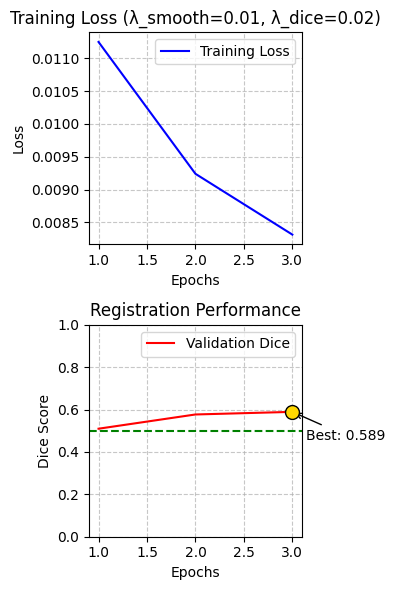

In [45]:
fig, axs = plt.subplots(2, 1, figsize=(4, 6))

############# YOUR CODES START #############
# Plot training loss
axs[0].plot(range(1, len(log_train_loss) + 1), log_train_loss, 'b-', label='Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title(f'Training Loss (λ_smooth={lam_smooth}, λ_dice={lam_dice})')
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].legend()

# Plot validation Dice score
axs[1].plot(range(val_interval, len(log_val_dice) * val_interval + 1, val_interval),
           log_val_dice, 'r-', label='Validation Dice')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Dice Score')
axs[1].set_title('Registration Performance')
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].set_ylim([0, 1])  # Dice score ranges from 0 to 1
axs[1].legend()

# Add horizontal line at initial dice score (before registration)
if len(log_val_dice) > 0:
    axs[1].axhline(y=dice_before, color='g', linestyle='--',
                  label=f'Before Registration: {dice_before:.3f}')
    # Add annotation for the best dice score
    best_epoch = log_val_dice.index(max(log_val_dice)) * val_interval + val_interval
    best_dice = max(log_val_dice)
    axs[1].scatter(best_epoch, best_dice, color='gold', s=100, zorder=5, edgecolor='black')
    axs[1].annotate(f'Best: {best_dice:.3f}',
                   (best_epoch, best_dice),
                   xytext=(10, -20),
                   textcoords='offset points',
                   arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.savefig(f'voxelmorph_training_smooth{lam_smooth}_dice{lam_dice}.png', dpi=300, bbox_inches='tight')
plt.show()
############# YOUR CODES END #############

## Visualize Registration Performance of Trained Network

#### Load the Pretrained Model and Perform Forward Pass


Please complete the code below

In [65]:
load_pretrained_model_weights = True  # Flag indicating whether to load pretrained model weights

if load_pretrained_model_weights:
    dir_load = dir_save  # Folder where network weights are stored
    # Instantiate warp layer
    warp_layer = Warp().to(device)

    ############# YOUR CODES START #############

    model = VoxelMorph(
        inshape=image_shape,  # Use actual image dimensions
        nb_unet_features=[
            [16, 32, 32, 32],             # encoder features
            [32, 32, 32, 32, 32, 16, 16]  # decoder features
        ],
        int_steps=7,                      # Number of scaling and squaring steps
        int_downsize=2,                   # Downsampling factor for integration
        src_feats=1,                      # Number of source image channels
        trg_feats=1,                      # Number of target image channels
        unet_half_res=False               # Use full resolution
    )

    ############# YOUR CODES END #############

    # Load model weights
    filename_best_model = glob.glob(os.path.join(dir_load, "voxelmorph_loss_best_dice_*"))[0]
    model.load_state_dict(torch.load(filename_best_model), strict=False)
    # Transfer model to GPU
    model.to(device)

# Set seed for reproducibility
set_determinism(seed=1)

# Prepare dataset and dataloader for validation
check_ds = Dataset(data=val_files, transform=transform_val)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)

# Get data from the validation dataset
fixed_image = check_data["fixed_image"].to(device)
moving_image = check_data["moving_image"].to(device)
fixed_label_4 = check_data["fixed_label_4"].to(device)
moving_label_4 = check_data["moving_label_4"].to(device)
fixed_label_35 = check_data["fixed_label_35"].to(device)
moving_label_35 = check_data["moving_label_35"].to(device)

# Forward pass
model.eval()
with torch.no_grad():
    with torch.cuda.amp.autocast(enabled=amp_enabled):
        ddf_image, pred_image, pred_label_one_hot = forward(
            fixed_image, moving_image, moving_label_35, model, warp_layer, num_classes=35
        )


In [64]:
# Load model weights while ignoring unexpected keys
state_dict = torch.load(filename_best_model)
model.load_state_dict(
    {k: v for k, v in state_dict.items() if 'integrate.transformer.grid' not in k},
    strict=False
)

<All keys matched successfully>

#### Visualization of the Fixed/Moving/Moved Images and Labels

## 🚩 YOUR TASK: Result Visualization
Extract and show the 100-th coronal slice

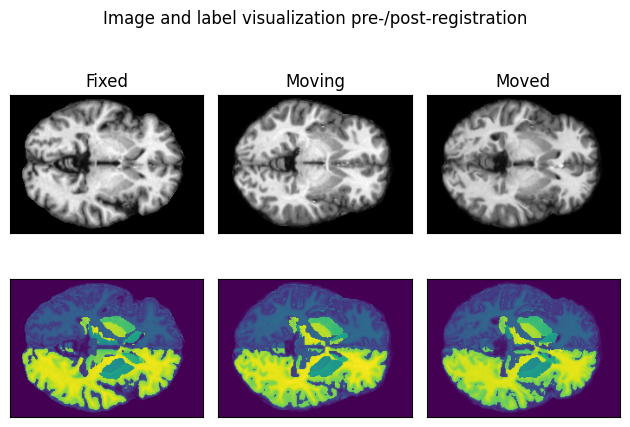

In [67]:
# Image and label visualization
def visualize(fixed_image, fixed_label, moving_image, moving_label, pred_image, pred_label_one_hot):
    # remove the batch dimension and move to cpu
    fixed_image = fixed_image.squeeze(0).cpu()
    fixed_label = fixed_label.squeeze(0).cpu()
    moving_image = moving_image.squeeze(0).cpu()
    moving_label = moving_label.squeeze(0).cpu()
    pred_image = pred_image.squeeze(0).cpu()
    pred_label = pred_label_one_hot.argmax(dim=1, keepdim=True).squeeze(0).cpu()

    # blend image and label
    fixed_blended = blend_images(fixed_image, fixed_label)
    moving_blended = blend_images(moving_image, moving_label)
    pred_blended = blend_images(pred_image, pred_label)

    ############# YOUR CODES START #############

    # extract coronal slice 100
    fixed_image = fixed_image[0, :, 100, :]
    moving_image = moving_image[0, :, 100, :]
    pred_image = pred_image[0, :, 100, :]

    fixed_blended = fixed_blended[0, :, 100, :]
    moving_blended = moving_blended[0, :, 100, :]
    pred_blended = pred_blended[0, :, 100, :]

    ############# YOUR CODES END #############

    # create plot
    fig, axs = plt.subplots(2, 3)
    axs[0, 0].imshow(fixed_image, cmap="gray")
    axs[0, 0].title.set_text("Fixed")
    axs[0, 1].imshow(moving_image, cmap="gray")
    axs[0, 1].title.set_text("Moving")
    axs[0, 2].imshow(pred_image, cmap="gray")
    axs[0, 2].title.set_text("Moved")
    axs[1, 0].imshow(fixed_blended)
    axs[1, 1].imshow(moving_blended)
    axs[1, 2].imshow(pred_blended)

    # remove ticks on all axes
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

    # set title
    plt.suptitle("Image and label visualization pre-/post-registration")
    plt.tight_layout()
    plt.show()


visualize(fixed_image, fixed_label_35, moving_image, moving_label_35, pred_image, pred_label_one_hot)